In [1]:
#hide
%load_ext autoreload
%autoreload 2

# Image Captioning with Transformers

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms as T

In [3]:
import math
from random import randint
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import OrderedDict

In [4]:
import timm

In [5]:
plt.rcParams['figure.facecolor'] = 'white'

In [6]:
# TODO: Try pre trained CLIP

# Download Dataset and Annotations

In [7]:
from torchvision.datasets.utils import download_and_extract_archive

In [8]:
DATA_DIR = "../datasets/COCO"

In [9]:
# download_and_extract_archive("http://images.cocodataset.org/zips/train2017.zip",
#                              download_root=DATA_DIR,
#                              remove_finished=True)

In [10]:
# download_and_extract_archive("http://images.cocodataset.org/zips/val2017.zip",
#                              download_root=DATA_DIR,
#                              remove_finished=True)

In [11]:
# download_and_extract_archive("http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
#                              download_root=DATA_DIR,
#                              remove_finished=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing Transforms

In [13]:
input_size = 224

In [223]:
preproc = {
    'train': T.Compose([
        T.RandomResizedCrop(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.RandomHorizontalFlip(input_size),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': T.Compose([
        T.Resize(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(input_size),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Dataset utils

In [15]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext

## Read COCO dataset

In [16]:
cap_data = datasets.CocoCaptions(root=DATA_DIR+"/val2017/",
                                 annFile=DATA_DIR+"/annotations/captions_val2017.json",
                                 transform=preproc['val'])

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


## Tokenizer and Build Vocab

In [17]:
tokenizer = get_tokenizer('basic_english')

In [18]:
def yield_tokens(cap_data):
    for ann in cap_data.coco.anns.values():
        yield tokenizer(ann['caption'])

In [19]:
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
en_vocab = build_vocab_from_iterator(yield_tokens(cap_data), specials=special_symbols, special_first=True)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = en_vocab(special_symbols)
en_vocab.set_default_index(UNK_IDX)

## Pretrained Glove Embeddings (not used rn)

In [20]:
# vec = torchtext.vocab.GloVe('6B', dim=300)

In [21]:
# unk_vec = vec.vectors.mean(dim=0)

In [22]:
# vec.unk_init = lambda x: unk_vec

In [23]:
# vec.get_vecs_by_tokens(tokens, lower_case_backup=True)

# Model Parameters

In [24]:
import wandb

In [25]:
config_defaults = {
    'tgt_vocab_size'    : len(en_vocab),
    'BATCH_SIZE'        : 32,
    'd_model'           : 512,
    'dim_feedforward'   : 2048,
    'nheads'            : 8,
    'num_decoder_layers': 6,
    'dp_rate'           : 0.1,
    'encoder'           : 'seresnext50_32x4d',
    'activation'        : 'gelu',
    'ilr'               : 1,
    'betas'             : (0.9, 0.98),
    'eps'               : 1e-9,
    'use_amp'           : True,
    'use_pe'            : True,
    'log_interval'      : 5,
}
CONFIG = config_defaults

In [26]:
#hide
# run = wandb.init(id='352vnm9l', project="Image_Captioning_Transformer", resume='must')
# CONFIG = run.config

In [27]:
# run = wandb.init(project="Image_Captioning_Transformer", entity="shivamshrirao", config=config_defaults)
# CONFIG = wandb.config

# Load dataset into batches

In [28]:
def generate_batch(data_batch):
    img_batch, cap_batch = [], []
    for img, caps in data_batch:
        img_batch.append(img)
        cap = caps[randint(0,len(caps)-1)]
        cap_batch.append(torch.tensor([BOS_IDX] + en_vocab(tokenizer(cap)) + [EOS_IDX]))

    cap_batch = pad_sequence(cap_batch, batch_first=False, padding_value=PAD_IDX)
    return torch.stack(img_batch), cap_batch

In [29]:
val_loader = torch.utils.data.DataLoader(cap_data,
                                         batch_size=CONFIG['BATCH_SIZE'],
                                         shuffle=True,
                                         num_workers=3,
                                         pin_memory=True,
                                         collate_fn=generate_batch)

# Initialize Model

In [30]:
from imcap.layers import *
from imcap.utils import *

In [31]:
# inp = torch.randn((1,3,224,224))

In [32]:
encoder = timm.create_model(CONFIG['encoder'], pretrained=False, num_classes=0, global_pool='')

In [33]:
# out = encoder(inp).flatten(-2).permute(2,0,1)

In [34]:
# out.shape

In [35]:
# ph = ProjectionHead()

In [36]:
# ph(out).shape

In [37]:
model = CaptionModel(encoder = encoder,
                     vocab_size = CONFIG['tgt_vocab_size'],
                     num_decoder_layers = CONFIG['num_decoder_layers'],
                     nheads = CONFIG['nheads'],
                     d_model = CONFIG['d_model'],
                     dim_feedforward = CONFIG['dim_feedforward'],
                     dp_rate = CONFIG['dp_rate'],
                     activation = CONFIG['activation']).to(device)

/usr/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [38]:
# img, cap = next(iter(val_loader))

In [39]:
# img = img.to(device)
# cap = cap.to(device)

In [40]:
# tgt_mask, tgt_pad_mask = subsequent_mask(cap.size(0), device), padding_mask(cap, PAD_IDX)
# tgt_mask.shape, tgt_pad_mask.shape

In [41]:
# with torch.no_grad():
#     o = model(img, cap, tgt_mask, tgt_pad_mask)

In [42]:
# o.shape

# Learning Rate Schedule

In [43]:
steps_per_epoch = len(val_loader)

In [44]:
def lr_schedule(step, d_model=512, warmup_steps=2*steps_per_epoch):
    # return 1
    step = max(1,step)
    arg1 = step ** -0.5
    arg2 = step * (warmup_steps ** -1.5)
    return (d_model ** -0.7) * min(arg1, arg2)

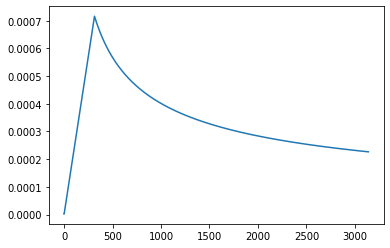

In [45]:
plt.plot(list(map(lr_schedule, range(steps_per_epoch*20))))
plt.show()

# Loss Function and Optimizer

In [46]:
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG['ilr'], betas=CONFIG['betas'], eps=CONFIG['eps']
)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)

scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])

# Log model

In [47]:
from torch.utils.tensorboard import SummaryWriter

In [48]:
# writer = SummaryWriter(run.dir+'/tensorboard_logs/imcap')

In [49]:
# src, tgt = next(iter(train_iter))
# src = src.to(device)
# tgt = tgt.to(device)
# writer.add_graph(model, (src, tgt))
# writer.close()
# del src, tgt

In [50]:
# wandb.watch(model, log=None)

In [51]:
from torch.cuda import amp

In [68]:
def train_epoch(model, train_iter, optimizer, scaler, scheduler, epoch=1, use_amp=True, log_interval=10):
    model.train()
    model.encoder.eval()
    losses = 0
    with tqdm(enumerate(train_iter), total=len(train_iter), desc=f"Epoch {epoch}") as pbar:
        for idx, (img, tgt) in pbar:
            img = img.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:-1,:]      # give input until before the last word.
            tgt_out = tgt[1:, :]      # predict the last word based on input and already predicted sentence. (auto-regressive)

            tgt_mask, tgt_pad_mask = subsequent_mask(tgt_inp.size(0), device), padding_mask(tgt_inp, PAD_IDX)

            optimizer.zero_grad(set_to_none=True)
            with amp.autocast(enabled=use_amp):
                logits = model(img, tgt_inp, tgt_mask, tgt_pad_mask)
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            losses+= loss.item()
            avg_loss = losses/(idx+1)
            curr_lr = optimizer.param_groups[0]['lr']
            info = {'loss': avg_loss, 'lr': curr_lr}

#             if not idx%log_interval: wandb.log(info)
            pbar.set_postfix(info)

    optimizer.zero_grad(set_to_none=True)
    return losses/len(train_iter)

In [69]:
def evaluate(model, val_iter, use_amp=True):
    model.eval()
    losses = 0
    with tqdm(enumerate(val_iter), total=len(val_iter), desc="Evaluating") as pbar:
        for idx, (img, tgt) in pbar:
            img = img.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:-1,:]      # give input until before the last word.
            tgt_out = tgt[1:, :]      # predict the last word based on input and already predicted sentence. (auto-regressive)

            tgt_mask, tgt_pad_mask = subsequent_mask(tgt_inp.size(0), device), padding_mask(tgt_inp, PAD_IDX)
            
            with amp.autocast(enabled=use_amp):
                logits = model(img, tgt_inp, tgt_mask, tgt_pad_mask)
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            losses+= loss.item()
            pbar.set_postfix({'val_loss': f"{losses/(idx+1):.3f}"})
    return losses/len(val_iter)

In [54]:
def save_model(model, optimizer, epoch):
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                }, run.dir + '/model.pth')

In [76]:
init_epoch = 1

In [56]:
NUM_EPOCHS = 20

In [77]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#collapse-output
for epoch in range(init_epoch, NUM_EPOCHS+1):
    train_loss = train_epoch(model, val_loader, optimizer, scaler, scheduler,
                             epoch, CONFIG['use_amp'], CONFIG['log_interval'])
    gc.collect(); torch.cuda.empty_cache()
    with torch.no_grad():
        val_loss = train_loss#evaluate(model, val_loader, CONFIG['use_amp'])
#     wandb.log({"val_loss": val_loss, "epoch": epoch})
    print(f"Epoch: {epoch}/{NUM_EPOCHS}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}\n")
    # if not epoch%10:
    #     save_model(model, optimizer, epoch)

In [79]:
init_epoch = epoch

# Make Predictions

In [310]:
def greedy_decode(model, img, max_len=100, start_symbol=BOS_IDX):
    model.eval()
    img = img.to(device)
    enc_output = model.encode_image(img)
    tgt = torch.ones(1, 1).fill_(start_symbol).long().to(device)
    for i in range(max_len):
        tgt_mask = subsequent_mask(tgt.size(0), device)
        out = model.decode_text(tgt, enc_output, tgt_mask)
        out = out.transpose(0,1)
        prob = model.generator(out[:,-1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        tgt = torch.cat([tgt, torch.ones(1, 1).fill_(next_word).long().to(device)], dim=0)
        if next_word == EOS_IDX:
            break
    return tgt

def generate_caption(model, img, tgt_vocab, tokenizer):
    with torch.no_grad():
        tgt = greedy_decode(model, img, max_len=100, start_symbol=BOS_IDX).flatten()
    return " ".join(tgt_vocab.lookup_tokens(tgt.tolist())).replace("<bos>", "").replace("<eos>", "")

In [311]:
import os
import random

In [312]:
paths = os.listdir("../datasets/COCO/val2017/")

In [ ]:
img = Image.open("../datasets/COCO/val2017/"+random.choice(paths))
img

In [316]:
generate_caption(model, preproc['val'](img)[None,:], en_vocab, tokenizer)

' a plate of food with broccoli and vegetables . '